<a href="https://colab.research.google.com/github/amandarito/instanbul-hotels/blob/main/istanbulHotels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Istanbul Hotel Dataset

Task:

1. Perform EDA and Data Cleaning

2. You have to create clusters of hotels for your given city, from the text you have, you're free to use any approach although an example of this is through topic modeling, see https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24.

3. Explain what the clusters mean and how can we interpret those hotels.

4. Using FAISS notebook from the class, create a search engine for the hotel, which take in a query such as "hotel near downtown" and returns a hotel - I am not too concerned on how good the result is, just want you to implement a search approach using a step by step approach - implement different techniques discussed in class such as quantization (again the goodness of result is not imp - I want you to follow the steps)

5. Provide learning and reflection

## Import data and libraries

In [ ]:
!pip install -q kaggle
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import re

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import pyLDAvis
import pyLDAvis.gensim
import numpy as np
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list
!kaggle d download 'hamzafarooq50/hotel-listings-and-reviews'
!mkdir hotel-data
!unzip hotel-listings-and-reviews.zip -d hotel-data

mkdir: cannot create directory ‘/root/.kaggle’: File exists
ref                                                                title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
zusmani/pakistan-toshakhana-files                                  Pakistan ToshaKhana Files                             1MB  2023-03-15 16:25:43           2352        106  1.0              
ramkrijal/tomato-daily-prices                                      Tomato Daily Prices                                  10KB  2023-03-10 15:39:14           1351         45  1.0              
themrityunjaypathak/covid-cases-and-deaths-worldwide               Covid Cases and Deaths WorldWide                      8KB  2023-02-01 12:22:51          14579        476  1.0

In [ ]:
# word wrap display
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [ ]:
hotel_listings = pd.read_csv('hotel-data/HotelListInIstanbul__en2019100120191005.csv')
hotel_ratings = pd.read_csv('hotel-data/hotelReviewsInIstanbul__en2019100120191005.csv')

In [ ]:
hotel_listings.head()

,Unnamed: 0,hotel_name,url,locality,reviews,tripadvisor_rating,checkIn,checkOut,price_per_night,booking_provider,no_of_deals,hotel_features
0,0,White House Hotel Istanbul,http://www.tripadvisor.com/Hotel_Review-g29397...,Istanbul,4414,NaN,2019/10/01,2019/10/05,$176,Booking.com,10,NaN
1,1,Crowne Plaza Istanbul - Florya,http://www.tripadvisor.com/Hotel_Review-g29397...,Istanbul,406,NaN,2019/10/01,2019/10/05,NaN,Travelocity,16,NaN
2,2,GLK PREMIER Sea Mansion Suites & Spa,http://www.tripadvisor.com/Hotel_Review-g29397...,Istanbul,350,NaN,2019/10/01,2019/10/05,NaN,Travelocity,16,NaN
3,3,Basileus Hotel,http://www.tripadvisor.com/Hotel_Review-g29397...,Istanbul,2061,NaN,2019/10/01,2019/10/05,NaN,TripAdvisor,9,NaN
4,4,Baylosuites,http://www.tripadvisor.com/Hotel_Review-g29397...,Istanbul,91,NaN,2019/10/01,2019/10/05,NaN,TripAdvisor,0,NaN


In [ ]:
hotel_ratings.head()

,Unnamed: 0,review_body,review_date,hotelName,hotelUrl
0,0,It was a pleasure staying at this hotel. Excel...,"July 12, 2019",0 White House Hotel Istanbul\nName: hotel_n...,http://www.tripadvisor.com/Hotel_Review-g29397...
1,1,"As everyone seems to agree, this is a wonderfu...","July 10, 2019",0 White House Hotel Istanbul\nName: hotel_n...,http://www.tripadvisor.com/Hotel_Review-g29397...
2,2,Even the glowing reviews I had read did not pr...,"July 10, 2019",0 White House Hotel Istanbul\nName: hotel_n...,http://www.tripadvisor.com/Hotel_Review-g29397...
3,3,Beautiful hotel located in the heart of the ci...,"July 9, 2019",0 White House Hotel Istanbul\nName: hotel_n...,http://www.tripadvisor.com/Hotel_Review-g29397...
4,4,We had amazing service here! I’m planning anot...,"July 7, 2019",0 White House Hotel Istanbul\nName: hotel_n...,http://www.tripadvisor.com/Hotel_Review-g29397...


## EDA & Data Cleaning



1. Hotel listings
2. Hotel ratings

### Hotel Listings

In [ ]:
hotel_listings.describe()

,Unnamed: 0,reviews,tripadvisor_rating,no_of_deals,hotel_features
count,30.000000,30.000000,0.0,30.000000,0.0
mean,14.500000,681.000000,NaN,9.966667,NaN
std,8.803408,1079.604781,NaN,5.573851,NaN
min,0.000000,82.000000,NaN,0.000000,NaN
25%,7.250000,144.500000,NaN,9.250000,NaN
50%,14.500000,303.000000,NaN,11.000000,NaN
75%,21.750000,537.500000,NaN,13.000000,NaN
max,29.000000,4414.000000,NaN,17.000000,NaN


Below, note that in `tripadvisor_rating` and `hotel_features` there are no values. And in `price_per_night`, there are only 2 entries with values. We will have to rely on other columns to make clusters and recommendations.


In [ ]:
hotel_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          30 non-null     int64  
 1   hotel_name          30 non-null     object 
 2   url                 30 non-null     object 
 3   locality            30 non-null     object 
 4   reviews             30 non-null     int64  
 5   tripadvisor_rating  0 non-null      float64
 6   checkIn             30 non-null     object 
 7   checkOut            30 non-null     object 
 8   price_per_night     2 non-null      object 
 9   booking_provider    30 non-null     object 
 10  no_of_deals         30 non-null     int64  
 11  hotel_features      0 non-null      float64
dtypes: float64(2), int64(3), object(7)
memory usage: 2.9+ KB


This locality column is not useful when we are only analyzing Istanbul hotels.

In [ ]:
hotel_listings.locality.unique()

array(['Istanbul'], dtype=object)

Check in and check out date aren't very meaningful for us because they  only contain one unique values each.

In [ ]:
print(hotel_listings.checkIn.unique(), hotel_listings.checkOut.unique())

['2019/10/01'] ['2019/10/05']


There isn't much meaningful information in the URL either. It contains the name of hotel, but we already have a column of data for that.

In [ ]:
hotel_listings.url[0]

'http://www.tripadvisor.com/Hotel_Review-g293974-d1604061-Reviews-White_House_Hotel_Istanbul-Istanbul.html'

Let's now drop all the unimportant columns:

In [ ]:
to_drop = ['tripadvisor_rating', 'hotel_features', 'price_per_night', 'locality', 'checkIn', 'checkOut', 'Unnamed: 0', 'url']
hotel_listings1 = hotel_listings.drop(to_drop, axis='columns')
hotel_listings1.head()

,hotel_name,reviews,booking_provider,no_of_deals
0,White House Hotel Istanbul,4414,Booking.com,10
1,Crowne Plaza Istanbul - Florya,406,Travelocity,16
2,GLK PREMIER Sea Mansion Suites & Spa,350,Travelocity,16
3,Basileus Hotel,2061,TripAdvisor,9
4,Baylosuites,91,TripAdvisor,0


Now, we can explore the remaining data:

Each hotel is unique and there are 30 in total.

In [ ]:
hotel_listings1.hotel_name.count()

30

In [ ]:
hotel_listings1.hotel_name.value_counts()

White House Hotel Istanbul                   1
Crowne Plaza Istanbul - Florya               1
Jazz Hotel                                   1
Hotel Tulip House                            1
Robin's Nest                                 1
Artefes Hotel Istanbul                       1
Walton Hotels Galata                         1
Radisson Blu Hotel & Spa - Istanbul Tuzla    1
Arven Boutique Hotel                         1
Bucoleon by Cheers                           1
Sura Hagia Sophia Hotel                      1
Agva Riverangel Hotel                        1
MySuite Istanbul Cihangir Square             1
Cube Suites                                  1
Hotel Next2                                  1
Hotel Sultan Hill                            1
Lotus Hotel Istanbul                         1
Downtown Istanbul                            1
Hotel Amira Istanbul                         1
Emirhan Inn Apart Hotel                      1
Bosphorus Palace Hotel                       1
Dila Suites  

Histograms for numerical data. We can see the `# of reviews` skews right and the `number of deals` is split between none or many.

array([[<Axes: title={'center': 'reviews'}>,
        <Axes: title={'center': 'no_of_deals'}>]], dtype=object)

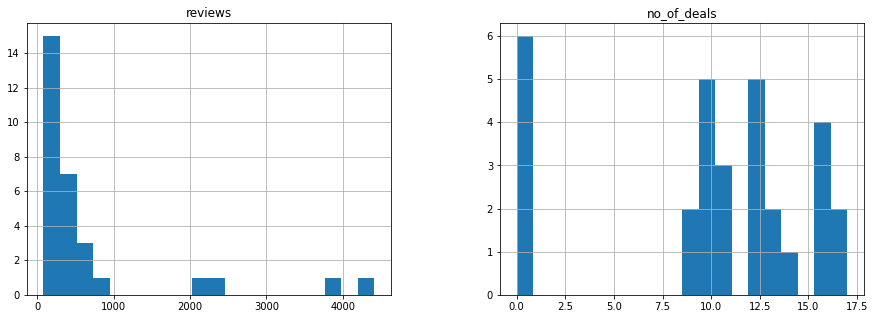

In [ ]:
hotel_listings1.hist(bins=20, figsize=(15, 5))

Booking provider spread. Mostly TripAdvisor, decent amount of Booking.com, then even spread along the last 3.

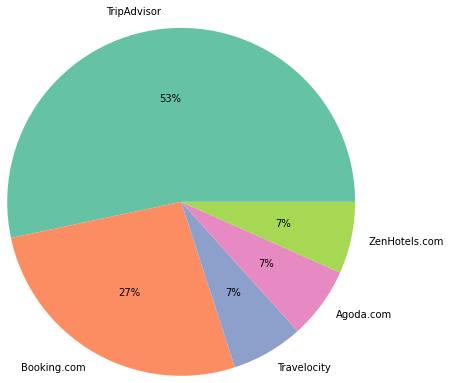

In [ ]:
hb_sizes = hotel_listings1.booking_provider.value_counts()
hb_labels = hotel_listings1.booking_provider.value_counts().keys()

colors = sns.color_palette('Set2')[0:5]

plt.pie(hb_sizes, labels=hb_labels, colors = colors, autopct='%.0f%%', radius=2)
plt.show()

### Hotel Reviews

In [ ]:
hotel_ratings.describe()

,Unnamed: 0
count,1433.00000
mean,716.00000
std,413.81578
min,0.00000
25%,358.00000
50%,716.00000
75%,1074.00000
max,1432.00000


This time, there are no null values.

In [ ]:
hotel_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1433 entries, 0 to 1432
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   1433 non-null   int64 
 1   review_body  1433 non-null   object
 2   review_date  1433 non-null   object
 3   hotelName    1433 non-null   object
 4   hotelUrl     1433 non-null   object
dtypes: int64(1), object(4)
memory usage: 56.1+ KB


Review body will be the most useful for content analysis.

In [ ]:
hotel_ratings.review_body

0       It was a pleasure staying at this hotel. Excel...
1       As everyone seems to agree, this is a wonderfu...
2       Even the glowing reviews I had read did not pr...
3       Beautiful hotel located in the heart of the ci...
4       We had amazing service here! I’m planning anot...
                              ...                        
1428    The hotel is beautifully decorated and the sta...
1429    We stayed in this hotel for five nights.the st...
1430    This small boutique hotel offers a truly "Turk...
1431    The breakfast room is on the top floor with st...
1432    We have had a wonderful stay at this lovely, f...
Name: review_body, Length: 1433, dtype: object

Review dates are less important, but can note that it spans from June 2015 to July 2019.

In [ ]:
hotel_ratings.review_date

0         July 12, 2019
1         July 10, 2019
2         July 10, 2019
3          July 9, 2019
4          July 7, 2019
             ...       
1428    August 21, 2015
1429    August 12, 2015
1430     August 5, 2015
1431      June 30, 2015
1432      June 16, 2015
Name: review_date, Length: 1433, dtype: object

These names are formatted poorly. We will have to remove the bit with `\n...` from each. The part appended is the same for all, so we can just remove the last 33 characters for each.

I also realized it has an extra number before it, we have to remove that too.

In [ ]:
hotel_ratings.hotelName.value_counts()

7    Taksim Ultra VIP Apartments\nName: hotel_name, dtype: object                   63
0    White House Hotel Istanbul\nName: hotel_name, dtype: object                    54
1    Crowne Plaza Istanbul - Florya\nName: hotel_name, dtype: object                54
28    Jazz Hotel\nName: hotel_name, dtype: object                                   54
27    Hotel Tulip House\nName: hotel_name, dtype: object                            54
25    Artefes Hotel Istanbul\nName: hotel_name, dtype: object                       54
24    Walton Hotels Galata\nName: hotel_name, dtype: object                         54
23    Radisson Blu Hotel & Spa - Istanbul Tuzla\nName: hotel_name, dtype: object    54
21    Bucoleon by Cheers\nName: hotel_name, dtype: object                           54
20    Sura Hagia Sophia Hotel\nName: hotel_name, dtype: object                      54
18    MySuite Istanbul Cihangir Square\nName: hotel_name, dtype: object             54
16    Hotel Next2\nName: hotel_name, dtype:

They are all good now:

In [ ]:
hotel_ratings1 = hotel_ratings.copy()
hotel_ratings1.hotelName = hotel_ratings1.hotelName.apply(lambda name : name[:-32])
hotel_ratings1.hotelName = hotel_ratings1.hotelName.apply(lambda name : ' '.join(name.split()[1:]))
hotel_ratings1.hotelName.unique()

array(['White House Hotel Istanbul', 'Crowne Plaza Istanbul - Florya',
       'GLK PREMIER Sea Mansion Suites & Spa', 'Basileus Hotel',
       'Baylosuites', 'Walnut Shell Hotel', 'Has Han Galata',
       'Taksim Ultra VIP Apartments', 'Elite World Business',
       'Dila Suites', 'Bosphorus Palace Hotel', 'Hotel Amira Istanbul',
       'Downtown Istanbul', 'Lotus Hotel Istanbul', 'Hotel Sultan Hill',
       'Hotel Next2', 'Cube Suites', 'MySuite Istanbul Cihangir Square',
       'Agva Riverangel Hotel', 'Sura Hagia Sophia Hotel',
       'Bucoleon by Cheers', 'Arven Boutique Hotel',
       'Radisson Blu Hotel & Spa - Istanbul Tuzla',
       'Walton Hotels Galata', 'Artefes Hotel Istanbul', "Robin's Nest",
       'Hotel Tulip House', 'Jazz Hotel', 'Hotel Valide Sultan Konagi'],
      dtype=object)

Except there is one which has no ratings. Without data, it won't be able to be clustered or a result in search later. Because of this, we don't really have to handle it.

In [ ]:
hotel_ratings1.hotelName.unique().shape

(29,)

Drop these columns because they don't add much useful content.

In [ ]:
to_drop = ['hotelUrl', 'review_date', 'Unnamed: 0']
hotel_ratings2 = hotel_ratings1.drop(to_drop, axis='columns')
hotel_ratings2.head()

,review_body,hotelName
0,It was a pleasure staying at this hotel. Excel...,White House Hotel Istanbul
1,"As everyone seems to agree, this is a wonderfu...",White House Hotel Istanbul
2,Even the glowing reviews I had read did not pr...,White House Hotel Istanbul
3,Beautiful hotel located in the heart of the ci...,White House Hotel Istanbul
4,We had amazing service here! I’m planning anot...,White House Hotel Istanbul


Quickly visualize at the remaining data:
- Review length skews right, so most are below 200 words.
- The spread of reviews per hotel is pretty much even except for `Agva Riveragnel Hotel` which only has a few.

<Axes: >

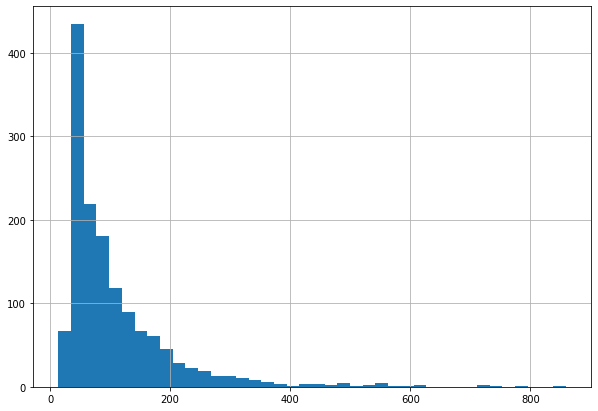

In [ ]:
hotel_ratings2.review_body.apply(lambda x : len(x.split())).hist(bins=40, figsize=(10, 7))

Most hotels have 40-60 reviews. Just one has less than 10.

<Axes: >

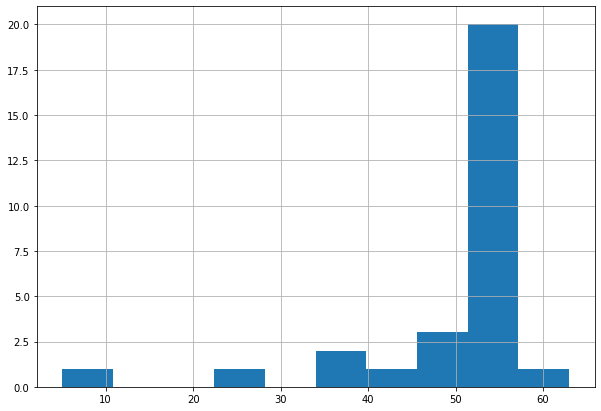

In [ ]:
hn_counts = hotel_ratings2.hotelName.value_counts()
hn_labels = hotel_ratings2.hotelName.value_counts().keys()
hn_counts.hist(bins=10, figsize=(10, 7))

The hotel with less than 10 ratings is Agva Riveragnel Hotel. It might be useful to remember this for when we do analysis on content, because this hotel will have fewer words to work with.

In [ ]:
print(hn_labels[-1], ':', hn_counts[-1])

Agva Riverangel Hotel : 5


## Clustering
1. Create bag of words for each hotel
2. Make clusters of hotels (topic modeling)
3. Visualize clusters

### Making bag of words

First, I'm making a new dataframe which only contains the name of each hotel and a column to store all 'words' for it.


In [ ]:
hotel_bagofwords = pd.DataFrame()
hotel_bagofwords['hotel_name'] = hotel_listings1.hotel_name
hotel_bagofwords['words'] = ''
hotel_bagofwords.set_index('hotel_name', inplace=True)
hotel_bagofwords.head()

,words
hotel_name,
White House Hotel Istanbul,
Crowne Plaza Istanbul - Florya,
GLK PREMIER Sea Mansion Suites & Spa,
Basileus Hotel,
Baylosuites,


Next, go through all reviews and create a string containing all the words in reviews for each hotel.

In [ ]:
for i, row in hotel_ratings2.iterrows():
  awords = hotel_bagofwords.loc[row.hotelName].words
  awords += ' '
  awords += row.review_body
  hotel_bagofwords.loc[row.hotelName, 'words'] = awords

In [ ]:
hotel_bagofwords.loc['Baylosuites'].words[:100]

' Baylosuites was a great location. Walking distant- 10 minutes from the Karakoy tram station. 2 minu'

Some further preprocessing is needed, such as applying lowercase, removing punctuation, and turning into a list. Compare the sample from Baylosuites above to the one below.

In [ ]:
hotel_bagofwords1 = hotel_bagofwords.copy()

# lowercase
hotel_bagofwords1.words = hotel_bagofwords.words.apply(lambda ws : ws.lower())

# replace [this/that this-that this.that this,that this!that this?that] -> this that
hotel_bagofwords1.words = hotel_bagofwords1.words.apply(lambda ws : ws.replace('/',' ')
.replace(',',' ').replace('.',' ').replace('-',' ').replace('?',' ').replace('!',' '))

# remove all other non alphabetic characters
regex = re.compile('[^a-zA-Z ]')
hotel_bagofwords1.words = hotel_bagofwords1.words.apply(lambda ws : regex.sub('', ws))

# turn into list (also handles whitespace)
hotel_bagofwords1.words = hotel_bagofwords1.words.apply(lambda ws : ws.split())
hotel_bagofwords1.loc['Baylosuites'].words[:15]

['baylosuites',
 'was',
 'a',
 'great',
 'location',
 'walking',
 'distant',
 'minutes',
 'from',
 'the',
 'karakoy',
 'tram',
 'station',
 'minutes',
 'from']

The current dataframe:

In [ ]:
hotel_bagofwords1

,words
hotel_name,
White House Hotel Istanbul,"[it, was, a, pleasure, staying, at, this, hote..."
Crowne Plaza Istanbul - Florya,"[this, hotel, location, is, awesome, and, refr..."
GLK PREMIER Sea Mansion Suites & Spa,"[it, was, an, experience, that, exceeded, my, ..."
Basileus Hotel,"[what, can, i, say, that, has, not, already, b..."
Baylosuites,"[baylosuites, was, a, great, location, walking..."
Walnut Shell Hotel,"[i, have, stayed, at, wslnut, shell, sevarel, ..."
Has Han Galata,"[great, service, truly, all, included, breakfa..."
Taksim Ultra VIP Apartments,"[actually, i, visited, it, more, than, once, b..."
Elite World Business,"[what, a, most, beautiful, hotel, the, front, ..."


In [ ]:
hotel_bagofwords1.drop(['Emirhan Inn Apart Hotel'], axis=0, inplace=True)

There is actually one hotel with no reviews and we should keep that in mind. It's called `Emirhan Inn Apart Hotel`. Since there is no content, we just drop it.

Next is some text preprocessing to help the topic modeling. To-do:
- Remove stopwords
  - These are common words that don't tell us anything about content, e.g. `these, or, it`.
- Apply stemming and/or lemmatization
  - This allows words like `started, starting, and start` to all be seen as the same. It helps us group words together better for topics.

In [ ]:
stemmer = SnowballStemmer('english')

# part of speech = verb because these have the most variety in endings
def lemmatize_stem(words):
  return stemmer.stem(WordNetLemmatizer().lemmatize(words, pos='v'))

# removes stopwords and otherwise short words, applies lemmatizer
def textprocess(words):
  processed = []
  for token in gensim.utils.simple_preprocess(words):
    if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
      processed.append(lemmatize_stem(token))

  return processed

Testing the functions from above. We have to join the list back together before the processing because `gensim` requires it.

In [ ]:
doc_sample = ' '.join(hotel_bagofwords1.loc['Baylosuites'].words.copy())
doc_sample[:100]

'baylosuites was a great location walking distant minutes from the karakoy tram station minutes from '

In [ ]:
print(textprocess(doc_sample)[:10])

['baylosuit', 'great', 'locat', 'walk', 'distant', 'minut', 'karakoy', 'tram', 'station', 'minut']


Now we know it works, we just have to apply this to all the existing bag-of-words.

In [ ]:
hotel_bagofwords2 = hotel_bagofwords1.copy()
hotel_bagofwords2['p_words'] = hotel_bagofwords1['words'].apply(lambda ws : textprocess(' '.join(ws)))

Looks good, and we can easily see the change of removing stopwords and applying lemmatization.

In [ ]:
hotel_bagofwords2

,words,p_words
hotel_name,,
White House Hotel Istanbul,"[it, was, a, pleasure, staying, at, this, hote...","[pleasur, stay, hotel, excel, staff, neat, cle..."
Crowne Plaza Istanbul - Florya,"[this, hotel, location, is, awesome, and, refr...","[hotel, locat, awesom, refresh, hotel, time, r..."
GLK PREMIER Sea Mansion Suites & Spa,"[it, was, an, experience, that, exceeded, my, ...","[experi, exceed, expect, time, visit, istanbul..."
Basileus Hotel,"[what, can, i, say, that, has, not, already, b...","[say, amaz, staff, amaz, locat, amaz, hotel, s..."
Baylosuites,"[baylosuites, was, a, great, location, walking...","[baylosuit, great, locat, walk, distant, minut..."
Walnut Shell Hotel,"[i, have, stayed, at, wslnut, shell, sevarel, ...","[stay, wslnut, shell, sevarel, time, refref, t..."
Has Han Galata,"[great, service, truly, all, included, breakfa...","[great, servic, truli, includ, breakfast, dedi..."
Taksim Ultra VIP Apartments,"[actually, i, visited, it, more, than, once, b...","[actual, visit, amaz, place, wonder, view, fri..."
Elite World Business,"[what, a, most, beautiful, hotel, the, front, ...","[beauti, hotel, desk, staff, help, good, under..."


### Create clusters (Topic modeling)

We will create clusters by doing analysis on the corpus as a whole compared to each 'document' (set of reviews for a hotel).
- It uses Latent Dirichlet Allocation (LDA).
- This will be done in code using the `gensim` library.

Next up is to create a 'dictionary' containing all words in our corpus and its term frequency. There is a preview of the start of the dictionary below.

In [ ]:
dictionary = gensim.corpora.Dictionary(hotel_bagofwords2['p_words'])
c = 0
for k, word in dictionary.iteritems():
  c += 1
  print(k, word)
  if c > 15:
    break

0 abl
1 absolut
2 access
3 accid
4 accommod
5 activ
6 actual
7 add
8 adirect
9 admir
10 advic
11 agre
12 airport
13 aleyna
14 altogeth
15 amaz


Below is a step which filters out words in less than 2 documents or more than 50% of documents.

In [ ]:
dictionary.filter_extremes(no_below = 2, no_above = 0.50, keep_n=100000)

In [ ]:
c = 0
for k, word in dictionary.iteritems():
  c += 1
  print(k, word)
  if c > 15:
    break

0 accid
1 activ
2 add
3 admir
4 agre
5 altogeth
6 ampl
7 answer
8 anytim
9 appar
10 appl
11 arm
12 artist
13 assort
14 attend
15 basilica


This step creates a count of words for each hotel. The word ID is first in the tuple, and frequency is second. We can use the dictionary to decode it.

In [ ]:
bow_corpus = [dictionary.doc2bow(doc) for doc in hotel_bagofwords2['p_words']]
bow_corpus[2][:10]

[(1, 2),
 (6, 1),
 (28, 1),
 (30, 1),
 (33, 1),
 (36, 2),
 (43, 1),
 (46, 4),
 (49, 1),
 (50, 1)]

In [ ]:
bow_hotel_3 = bow_corpus[2]
for i in range(len(bow_hotel_3)):
    print("word {} (\"{}\") appears {} times.".format(bow_hotel_3[i][0],
                        dictionary[bow_hotel_3[i][0]], bow_hotel_3[i][1]))

word 1 ("activ") appears 2 times.
word 6 ("ampl") appears 1 times.
word 28 ("chat") appears 1 times.
word 30 ("chill") appears 1 times.
word 33 ("classic") appears 1 times.
word 36 ("compani") appears 2 times.
word 43 ("courteous") appears 1 times.
word 46 ("cruis") appears 4 times.
word 49 ("daughter") appears 1 times.
word 50 ("decis") appears 1 times.
word 56 ("detail") appears 1 times.
word 60 ("eager") appears 1 times.
word 63 ("effici") appears 3 times.
word 64 ("eleg") appears 2 times.
word 68 ("enter") appears 1 times.
word 76 ("ferri") appears 1 times.
word 81 ("foot") appears 2 times.
word 83 ("fourth") appears 1 times.
word 86 ("gift") appears 1 times.
word 87 ("girl") appears 1 times.
word 94 ("hagia") appears 7 times.
word 99 ("haya") appears 1 times.
word 101 ("highlight") appears 2 times.
word 102 ("honest") appears 1 times.
word 106 ("husband") appears 2 times.
word 108 ("imagin") appears 2 times.
word 113 ("introduc") appears 1 times.
word 118 ("knowledg") appears 2 ti

 With the bag of words with frequency for each hotel, we now just have to figure out the most 'important' words. We can use gensim LDA to do this, and also print out the topics in order of word importance.
 - We have to manually determine the number of topics. We tried multiple runs with different values and found 5 to be a good amount without getting overly specific (like one cluster being one large hotel).
 - Each time the LDA is run, results may differ. We can run multiple times to find better results. It's better if topics are not overlapping.
 - The first 1-5 most important words are what we can use to infer the 'topic'.

In [ ]:
# np.random.seed(37) # LDA is not deterministic, I ran a few times and this is a good seed.
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=5, id2word=dictionary, passes=3, workers=2, chunksize=100, random_state=29)

In [ ]:
for id, topic in lda_model.print_topics(-1):
  print(f'topic: {id}\nwords: {topic}')

topic: 0
words: 0.016*"bosphorus" + 0.016*"hostel" + 0.010*"pool" + 0.009*"shuttl" + 0.007*"wed" + 0.007*"galata" + 0.005*"tower" + 0.005*"secur" + 0.005*"ultra" + 0.004*"bridg"
topic: 1
words: 0.017*"shuttl" + 0.010*"walnut" + 0.009*"shell" + 0.008*"hagia" + 0.006*"elev" + 0.005*"mansion" + 0.005*"galata" + 0.004*"massag" + 0.004*"bosphorus" + 0.004*"stair"
topic: 2
words: 0.026*"hagia" + 0.009*"topkapi" + 0.008*"hostel" + 0.008*"white" + 0.007*"sofia" + 0.006*"bosphorus" + 0.005*"pool" + 0.004*"late" + 0.004*"sultan" + 0.004*"cheer"
topic: 3
words: 0.020*"galata" + 0.010*"tower" + 0.007*"zeynep" + 0.007*"kitchen" + 0.007*"istikl" + 0.007*"card" + 0.006*"hill" + 0.005*"wine" + 0.005*"phone" + 0.004*"stair"
topic: 4
words: 0.018*"jazz" + 0.010*"amira" + 0.009*"music" + 0.008*"hagia" + 0.008*"omar" + 0.004*"istikl" + 0.004*"final" + 0.004*"galata" + 0.004*"compar" + 0.004*"cake"


### Visualize clusters

Visualization of LDA topics with help of: https://medium.com/analytics-vidhya/topic-modeling-using-gensim-lda-in-python-48eaa2344920
- It is an interactive graph.
- Hover over topic circles to get more info on it.

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary, R=10)
vis

/usr/local/lib/python3.9/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.012016 -0.060267       1        1  36.206309
0      0.092211 -0.000492       2        1  19.529272
2     -0.018493  0.070530       3        1  18.793783
4     -0.056915 -0.011103       4        1  15.873770
1     -0.004787  0.001332       5        1   9.596866, topic_info=           Term        Freq       Total Category  logprob  loglift
94        hagia  117.000000  117.000000  Default  10.0000  10.0000
1021       jazz   53.000000   53.000000  Default   9.0000   9.0000
387      hostel   71.000000   71.000000  Default   8.0000   8.0000
510      shuttl   70.000000   70.000000  Default   7.0000   7.0000
594   bosphorus   78.000000   78.000000  Default   6.0000   6.0000
...         ...         ...         ...      ...      ...      ...
94        hagia   11.016229  117.194916   Topic5  -4.8113  -0.0207
653       memor    4.528672   17.706434   Topic5  -5.7003   0.9802
1091      stair    5.115428   34.658650   Topic5  -5.5784   0.4304
797      galata    6.241960  137.244509   Topic5  -5.3794  -0.7467
594   bosphorus    5.231504   78.085782   Topic5  -5.5560  -0.3594

[122 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
720       1  0.144174  affect
720       3  0.144174  affect
720       4  0.576694  affect
573       1  0.457710  afford
573       2  0.050857  afford
...     ...       ...     ...
570       1  0.875164  zeynep
570       2  0.046061  zeynep
570       3  0.023031  zeynep
570       4  0.023031  zeynep
570       5  0.046061  zeynep

[338 rows x 3 columns], R=10, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 3, 5, 2])

## Explaining Clusters


From the above visualization, we see the difference between the 5 clusters. Smaller topics are more tightly clustered, and the large topics are more broad. Luckily with LDA, it's pretty easy to define the topics by hand. Just from looking at the top words, the 'topics' are basically:
1. Hagia Sophia
2. Shuttle
3. Galata Tower
4. Bosphorous River
5. Jazz Music

We can infer `Jazz Music` and `Shuttle` as features/amenities of hotels, whereas `Bosphorous`, `Hagia Sophia` and `Galata Tower` are points of interest.

Essentially, each cluster contains hotels that have or are nearby the topic.


Here we can go through each hotel in the corpus and find its most relevant topic:

In [ ]:
def top_topics(ldamodel, corpus, hotelnames):
  list_topics = []
  for i, row_list in enumerate(ldamodel[corpus]):
    row = row_list[0] if ldamodel.per_word_topics else row_list
    row = sorted(row, key = lambda x: (x[1]), reverse=True)
    for j, (topic_num, prop_topic) in enumerate(row):
      if j == 0: # dominant topic
        # print('topic', topic_num, ' -- ', hotelnames[i])
        list_topics.append(topic_num)
      else:
        break
  return list_topics

The topic_num value from the ldamodel is not very meaningful, it's just a value 0-4.

Recalling the topic labels from the below code, we can create a topic mapping to have a meaningful `topic` column in a dataframe.

In [ ]:
for id, topic in lda_model.print_topics(-1):
  print(f'topic: {id}\nwords: {topic}')

topic: 0
words: 0.016*"bosphorus" + 0.016*"hostel" + 0.010*"pool" + 0.009*"shuttl" + 0.007*"wed" + 0.007*"galata" + 0.005*"tower" + 0.005*"secur" + 0.005*"ultra" + 0.004*"bridg"
topic: 1
words: 0.017*"shuttl" + 0.010*"walnut" + 0.009*"shell" + 0.008*"hagia" + 0.006*"elev" + 0.005*"mansion" + 0.005*"galata" + 0.004*"massag" + 0.004*"bosphorus" + 0.004*"stair"
topic: 2
words: 0.026*"hagia" + 0.009*"topkapi" + 0.008*"hostel" + 0.008*"white" + 0.007*"sofia" + 0.006*"bosphorus" + 0.005*"pool" + 0.004*"late" + 0.004*"sultan" + 0.004*"cheer"
topic: 3
words: 0.020*"galata" + 0.010*"tower" + 0.007*"zeynep" + 0.007*"kitchen" + 0.007*"istikl" + 0.007*"card" + 0.006*"hill" + 0.005*"wine" + 0.005*"phone" + 0.004*"stair"
topic: 4
words: 0.018*"jazz" + 0.010*"amira" + 0.009*"music" + 0.008*"hagia" + 0.008*"omar" + 0.004*"istikl" + 0.004*"final" + 0.004*"galata" + 0.004*"compar" + 0.004*"cake"


Here is each hotel with its most relevant topic (and also its bag of words).

In [ ]:
hotel_topics = pd.Series(top_topics(lda_model, bow_corpus, hotel_bagofwords2.index.tolist()))
hotel_bagofwords3 = hotel_bagofwords2.copy().reset_index()
hotel_bagofwords3['topic'] = hotel_topics

topic_mapping = ['Bosphorous River', 'Shuttle', 'Hagia Sophia', 'Galata Tower', 'Jazz Music']
hotel_bagofwords3['topic'] = hotel_bagofwords3['topic'].apply(lambda t : topic_mapping[t])

hotel_bagofwords3

,hotel_name,words,p_words,topic
0,White House Hotel Istanbul,"[it, was, a, pleasure, staying, at, this, hote...","[pleasur, stay, hotel, excel, staff, neat, cle...",Hagia Sophia
1,Crowne Plaza Istanbul - Florya,"[this, hotel, location, is, awesome, and, refr...","[hotel, locat, awesom, refresh, hotel, time, r...",Bosphorous River
2,GLK PREMIER Sea Mansion Suites & Spa,"[it, was, an, experience, that, exceeded, my, ...","[experi, exceed, expect, time, visit, istanbul...",Shuttle
3,Basileus Hotel,"[what, can, i, say, that, has, not, already, b...","[say, amaz, staff, amaz, locat, amaz, hotel, s...",Jazz Music
4,Baylosuites,"[baylosuites, was, a, great, location, walking...","[baylosuit, great, locat, walk, distant, minut...",Galata Tower
5,Walnut Shell Hotel,"[i, have, stayed, at, wslnut, shell, sevarel, ...","[stay, wslnut, shell, sevarel, time, refref, t...",Shuttle
6,Has Han Galata,"[great, service, truly, all, included, breakfa...","[great, servic, truli, includ, breakfast, dedi...",Galata Tower
7,Taksim Ultra VIP Apartments,"[actually, i, visited, it, more, than, once, b...","[actual, visit, amaz, place, wonder, view, fri...",Bosphorous River
8,Elite World Business,"[what, a, most, beautiful, hotel, the, front, ...","[beauti, hotel, desk, staff, help, good, under...",Shuttle
9,Dila Suites,"[it, was, amazing, to, come, back, to, istanbu...","[amaz, come, istanbul, hotel, dila, suit, reas...",Jazz Music


## Hotel Search Engine

Using the FAISS notebook as a base, in this section we create a search engine for the hotels in Istanbul.

1. Build search model
2. Examples

### Create search model

In [ ]:
!pip install faiss-cpu
!pip install -U sentence-transformers
import faiss
import time
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('bert-base-nli-mean-tokens')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Get all reviews as a list. Then, we encode this data into the model (corpus).

The encoding takes a while because the reviews are quite long.

In [ ]:
review_sentences = hotel_ratings2['review_body'].tolist()

In [ ]:
# this takes a long time.
review_embeds = model.encode(review_sentences)

Now we can use FAISS to built the index.
We can also also create a search method which will use the `index.search`. It uses k = 5 nearest neighbors for this.

This `search` method will print the top 5 similar reviews and the name of the hotel. This way, it's easy for a user to tell which hotel they should choose when seeing the results.

In [ ]:
index = faiss.IndexFlatL2(review_embeds.shape[1])
index.add(review_embeds)
faiss.write_index(index, 'index_hotel_reviews')
index = faiss.read_index('index_hotel_reviews')

In [ ]:
def search(query):
  t = time.time()
  query_v = model.encode([query])
  k = 5
  top_k = index.search(query_v, k)
  print(f'total time: {time.time() - t}')
  results = [review_sentences[_id] for _id in top_k[1].tolist()[0]]
  for result in results:
    hotelName = hotel_ratings2.loc[hotel_ratings2['review_body'] == result].hotelName.to_string()
    print(' '.join(hotelName.split()[1:]))
    print('\t' + str(result) + '\n')

- This approach gets 5 most similar reviews, but there are many reviews for each hotel. So the quality of results is not perfect.
  - In the future, it could be an improvement to create summaries of all of each hotels' reviews and use those as the neighbor candidates.
- However, the output of this review-based method is easier to understand and implement for our needs.
  - You can easily see 5 people's testimonies and make judgements based off of that.
  - If you find one hotel's name multiple times in the 5 results, that is another indicator of relevance.

### Examples

In [ ]:
search('Jazz music')

total time: 0.08676552772521973
Jazz Hotel
	Jazz musicians who play in Istanbul often end up here, but you don't have to love jazz to enjoy this place.The location is great...very close to the metro and cosmopolitan Nisantasi. The place is unpretentious and friendly and isn't marred by the corporate coldness of business oriented hotels.

Jazz Hotel
	I higly recommend this hotel. the location was fantastic, in the heart of exclusive Nisantasi neighborhood. Minute walking distance from Abdi Ipekci and Tesekviye streets. Spacious rooms named after jazz artists with their custom made jazz playlists within each room. Lovely an professional stuff! If you're a jazz lover do not think twice and book this hotel!

Downtown Istanbul
	 Well managed hostel with good facilities. Quiet location but still close to transport and busy Beyoglu.Has a good rooftop terrace to hang out which is good place to meet fellow travellers. Would stay here again.

Jazz Hotel
	istanbul, city of 24/7 restlessness. jazz

In [ ]:
search('Good food')

total time: 0.0951087474822998
Hotel Tulip House
	the location is fantastic, the service & food can't be faulted. It is really close to Sofia Hagia, shopping & some really good restaurants. The room is small but makes up for it in cleanliness. Would definitely stay there again.

Basileus Hotel
	So appreciated to be tasted this excellent cuisine. It has a lot of choices. And the equip that serve our dishes were nice guys. Especially a guy whose name is emre was brilliant and funny. Tank you for everything.

Hotel Next2
	Very nice hotel with friendly staff ..they help us alot ..hotel is very near to istiklal street ..great location ..feeling safe n secure..nice room .. having enough space ..tidy .. fooding r also good..

Bosphorus Palace Hotel
	the bosphorus palace hotel is a very quite and romantic place where the history meets the modern istanbul.silens...sea...lights of the bridges...exellent service...best quality of food and very good location.

Agva Riverangel Hotel
	I truly enjoye

In [ ]:
search('Walking access')

total time: 0.10044527053833008
Bucoleon by Cheers
	In the middle of ancient streets of Istanbul, the hotel is comfortable, clean, well preserved and has an excellent breakfeast and service. As it is close to the Sultanahmet and Küçuk Ayasofya, even a short walk around worths.

Cube Suites
	The location of the hotel is great, you can easily walk everywhere. The neighbourhood is in evolution and you can find hidden gems. The staff was extraordinarily nice and very helpful. The room was renovated and clean. I would go back in a minute

Downtown Istanbul
	The relation price and quality is really nice and the stuff is amazing.... people so gentle and kind...The location close to Galata Tower is great.. easy to get Sultanahmet by Tram or Taksim square by walk... Muchas Gracias, José (chileno)

Hotel Valide Sultan Konagi
	I have been staying here for about eleven years now....When I arrive I feel like I'm coming home...a small, comfortable, clean & hospitable venue...location is outstanding 

In [ ]:
search('Airport nearby')

total time: 0.14692449569702148
Crowne Plaza Istanbul - Florya
	Beautiful hotel and good service.It is located in a very good situation, by the sea.Good views and several different ambients.Very close to the airport, may be a bit noisy because is located in the final approach of the Atatürk International Airport... but still good.

Elite World Business
	Great dealing led by Özkan Yilmaz and hotel is very near to the Airport. Wishing the best for him prompt kind supportive person. Internet in the hotel is amazing and they have free shuttles to Taksim and Sultan Ahmed areas. 

Dila Suites
	It was amazing to come back to Istanbul, to hotel Dila Suites. There are many reasons for this statement. Among others, these are: hotel is located in the Pera/Beyoglu district of the city and very close to Taksim Square, public transport in front of hotel, aeroport 20 km away. Refreshment ,recreational and shoping venues within few meters from hotel. Rooms air-contioned. And finaly, the staff are very

In [ ]:
search('Bad experience')

total time: 0.10050821304321289
Jazz Hotel
	The room smelled the sewage all the time. The hotel was very small and had a total of 12 rooms. The room was not very clean. The cost of the room was very high in terms of service, in general, it was not a good hotel at all.

Bucoleon by Cheers
	First of all, do not believe in the pictures of this place, they are showing us fake pictures of this place, totally photoshopped. To make it short:- The rooms are not at all like the pictures, in fact, they smell very bad, the place is full of refugees (very loud people). Barely clean...- They FORCE you to pay by cash and they refuse to give you bill if you ask for it.If you insist on getting the bill they will put you out of their hotel (very rude and aggressive staff). The reason they do not give a bill: if you book with agoda/booking, they cancel your reservation so you CAN NOT write a review in those websites, without the bill you can not prove you were there.Many bad surprises in this place, do 

## Learnings and Reflection

EDA

- Lots of columns were not needed or redundant, so we dropped or modified those.
- The majority of EDA was cleaning up the `review_body` data.
- We had to handle punctuation, numbers, spacing, and non-latin characters in different ways. We also have to apply lowercase to all words.
- There was also one hotel with no reviews, which was dropped because it would be meaningless to cluster it with no data.

Clustering

- For clustering, we decided on a bag of words approach. This required lemmatization of the words.
- We used Latent Dirichlet Allocation (LDA) to preform topic modeling. We had to fine-tune some hyperparameters of the LDA model to get the best results. These hyperparameters include # of topics, random state, and passes.
- We also found a tool to visualize the topics, which was helpful for analysis.

Search

- Following the steps from the class notebook, we created a content-based search function for hotels.
- We were able to test it with some sample queries, and found relevant results.
- We verified the top results using online information about the hotels.

Further Improvements

- For clustering, we could try TF-IDF & bigram approach as a preprocessing step.
- For search, we could speed up serach time using quantization.